<a href="https://colab.research.google.com/github/LeoFernanndes/notebooks/blob/master/hackathon_bank.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hackaton Bank Binary Imbalanced Classification

In [10]:
!git clone https://github.com/LeoFernanndes/functions

fatal: destination path 'functions' already exists and is not an empty directory.
fatal: destination path 'functions' already exists and is not an empty directory.


### Data discovery

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

url_train = 'https://raw.githubusercontent.com/LeoFernanndes/datasets/master/bank.csv'
url_full = 'https://raw.githubusercontent.com/LeoFernanndes/datasets/master/bank_full.csv'

bank_ = pd.read_csv(url_train, sep= ';')
bank_full = pd.read_csv(url_full, sep = ';')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
bank = bank_.copy()

In [13]:
bank.describe()

,age,balance,day,duration,campaign,pdays,previous
count,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000
mean,41.170095,1422.657819,15.915284,263.961292,2.793630,39.766645,0.542579
std,10.576211,3009.638142,8.247667,259.856633,3.109807,100.121124,1.693562
min,19.000000,-3313.000000,1.000000,4.000000,1.000000,-1.000000,0.000000
25%,33.000000,69.000000,9.000000,104.000000,1.000000,-1.000000,0.000000
50%,39.000000,444.000000,16.000000,185.000000,2.000000,-1.000000,0.000000
75%,49.000000,1480.000000,21.000000,329.000000,3.000000,-1.000000,0.000000
max,87.000000,71188.000000,31.000000,3025.000000,50.000000,871.000000,25.000000


,age,balance,day,duration,campaign,pdays,previous
count,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000
mean,41.170095,1422.657819,15.915284,263.961292,2.793630,39.766645,0.542579
std,10.576211,3009.638142,8.247667,259.856633,3.109807,100.121124,1.693562
min,19.000000,-3313.000000,1.000000,4.000000,1.000000,-1.000000,0.000000
25%,33.000000,69.000000,9.000000,104.000000,1.000000,-1.000000,0.000000
50%,39.000000,444.000000,16.000000,185.000000,2.000000,-1.000000,0.000000
75%,49.000000,1480.000000,21.000000,329.000000,3.000000,-1.000000,0.000000
max,87.000000,71188.000000,31.000000,3025.000000,50.000000,871.000000,25.000000


In [14]:
soma = 0
for column in bank.columns:
  if bank[column].dtype == 'object':
    n = bank.loc[bank[column].isnull() == True].count()    
    bank[column].value_counts(), '\n'   
    soma +=0
print('Sum of null values across the dataframe = {}'.format(soma))

Sum of null values across the dataframe = 0
Sum of null values across the dataframe = 0


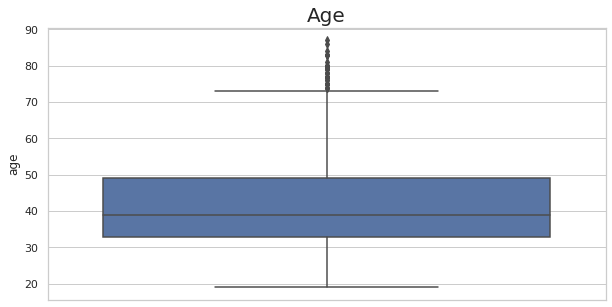

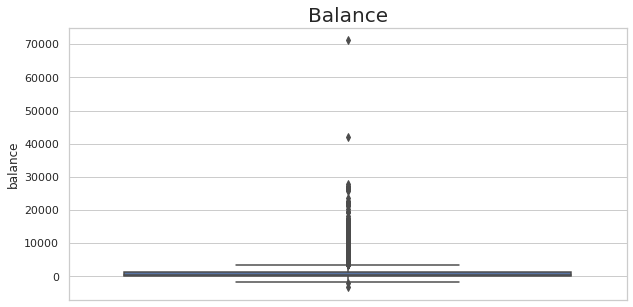

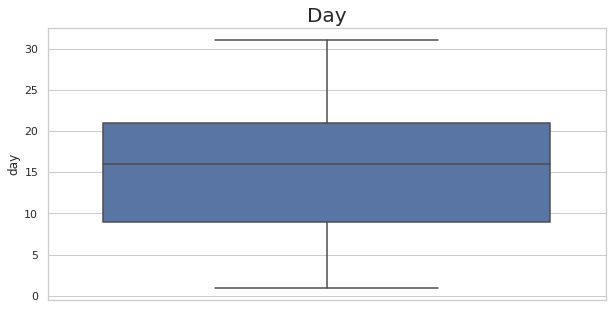

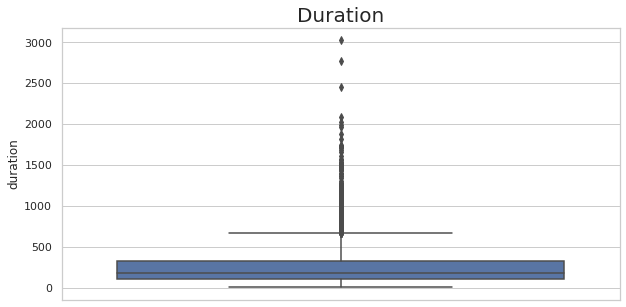

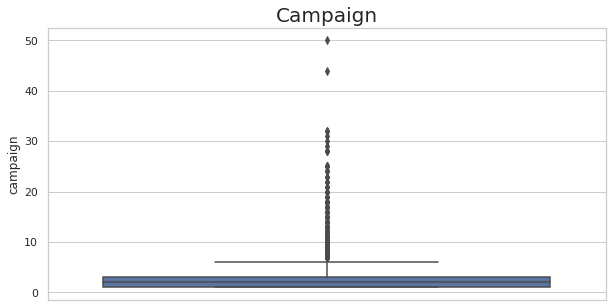

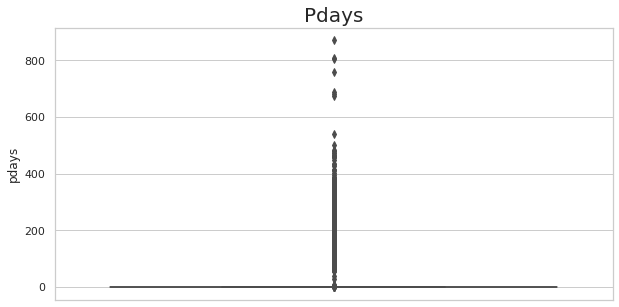

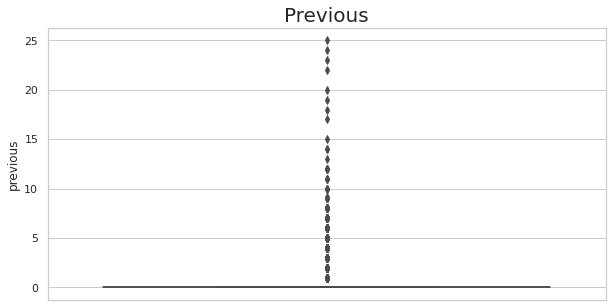

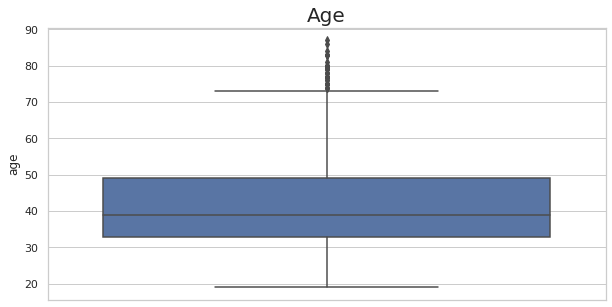

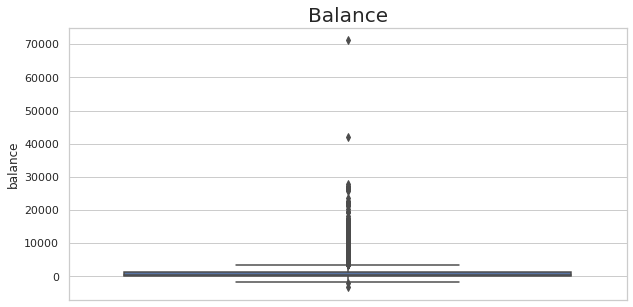

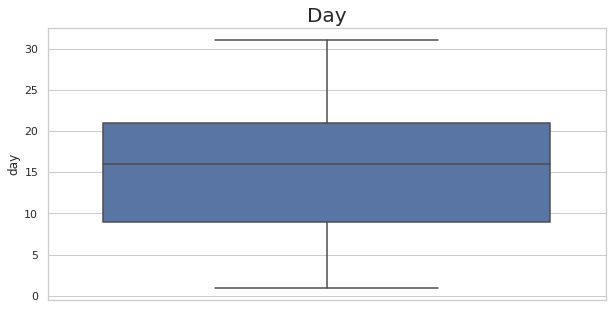

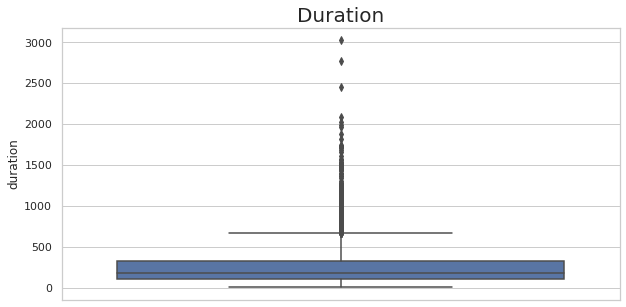

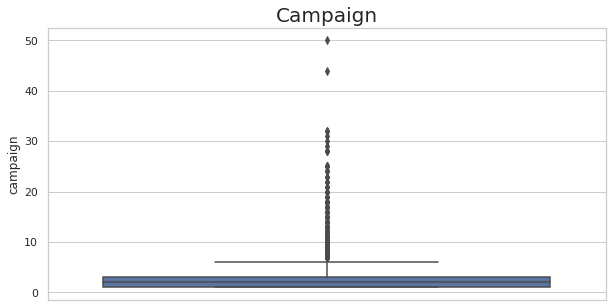

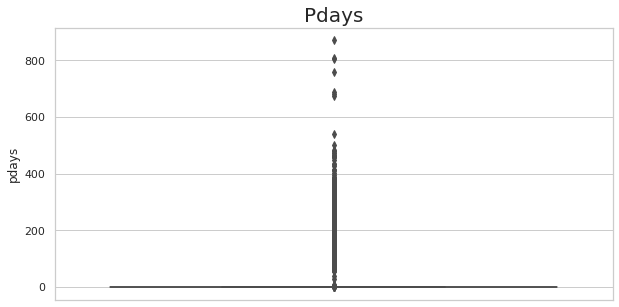

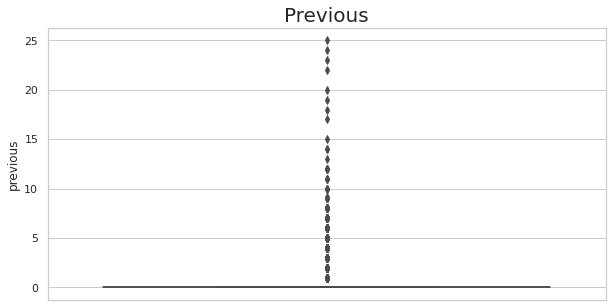

In [15]:
# boxplots
bank = bank_.copy()

for column in bank.columns:
  if bank[column].dtype == 'float' or bank[column].dtype == 'int':
    plt.figure(figsize= (10, 5))
    sns.set(style= 'whitegrid')
    fig1 = sns.boxplot(y= column, data= bank)
    plt.title('{}'.format(column.title()), size= 20)
    plt.show()

    print()

### Baseline model

In [16]:
# testing a naive classification model just balancing the classes inside random forest

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier 
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix


bank = bank_.copy()

for column in bank.columns:
  if bank[column].dtype == 'object' or bank[column].dtype == 'str':
    le = LabelEncoder()
    le.fit(bank[column])
    bank[column] = le.transform(bank[column])

x = bank.drop(['y'], axis= 1)
y = bank['y']

x_train, x_test, y_train, y_test = train_test_split(x, y, train_size= 0.7, random_state= 42)

clf = RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight={1:1, 0:7.5},
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42,
                       verbose=0, warm_start=False)

clf.fit(x_train, y_train)

y_pred = clf.predict(x_test)
y_real = y_test

f1 = f1_score(y_real, y_pred)
cm = confusion_matrix(y_real, y_pred)
ac = accuracy_score(y_real, y_pred)

print('f1: {}, accuracy score: {}'.format(f1, ac))
print(cm)

f1: 0.4615384615384615, accuracy score: 0.9019896831245394
[[1167   38]
 [  95   57]]
f1: 0.4615384615384615, accuracy score: 0.9019896831245394
[[1167   38]
 [  95   57]]


#### As we can see here, the first attempt to implement a classification model without any regards on data preprocessing led us to a very low f1 score and even though the achievement of a high accuracy score, we must consider the imbalance between classes which by itself leads us to 88% on this metric.

### Data preprocessing

#### Let's first look back into the boxplots to understand better the distribuition of the data

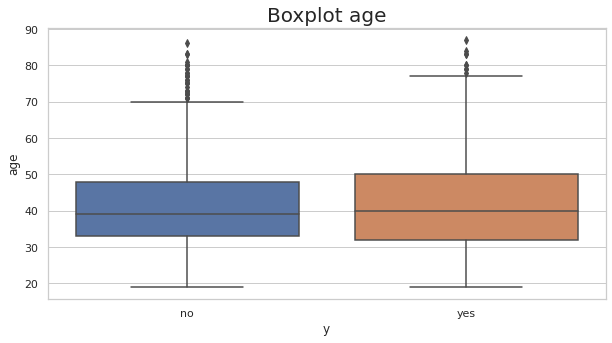

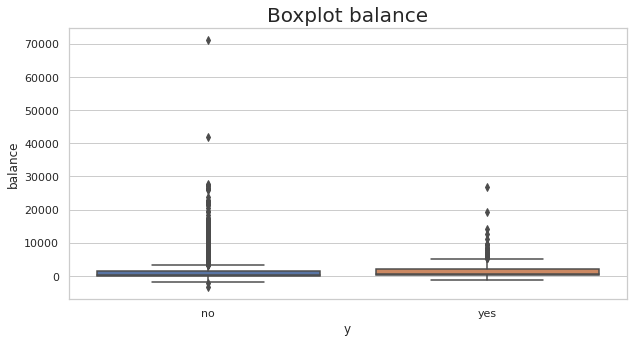

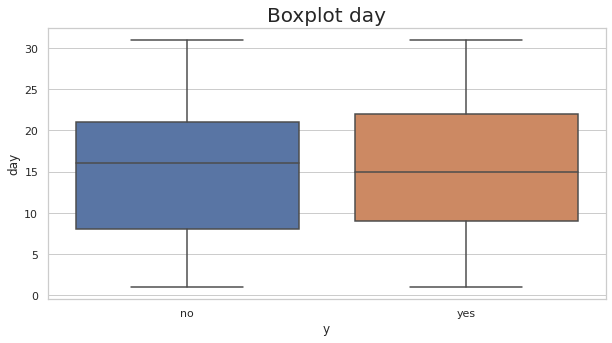

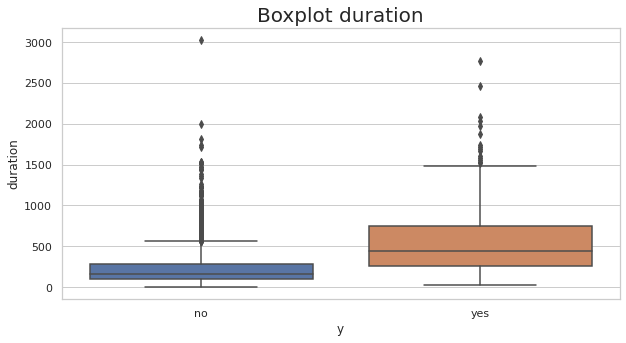

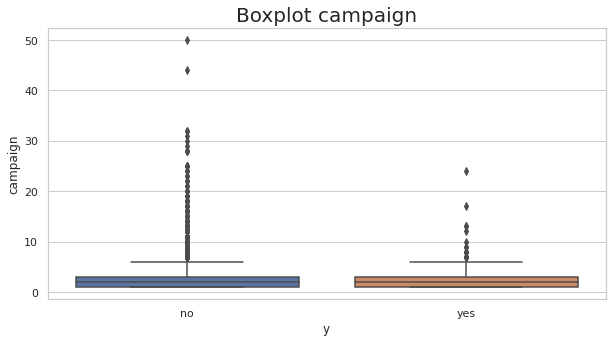

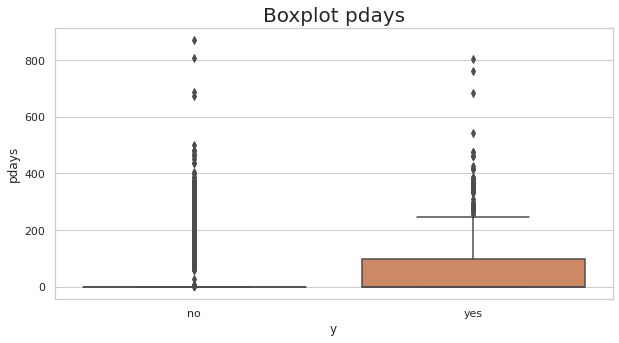

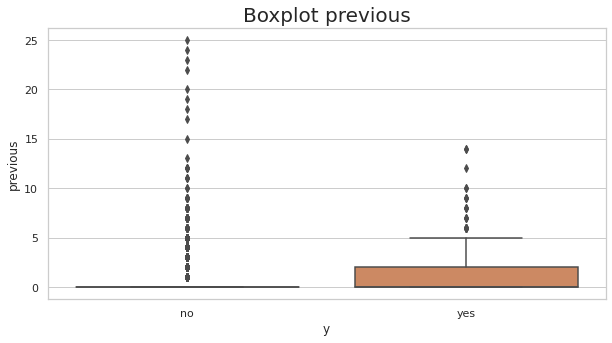

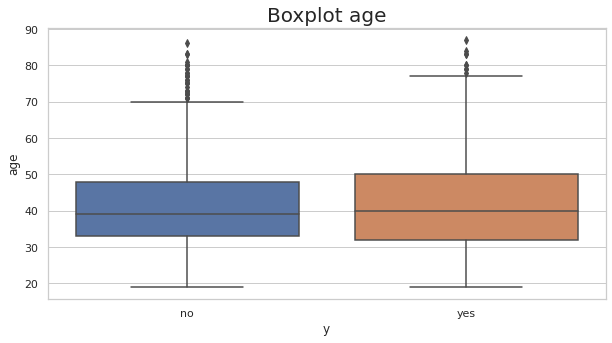

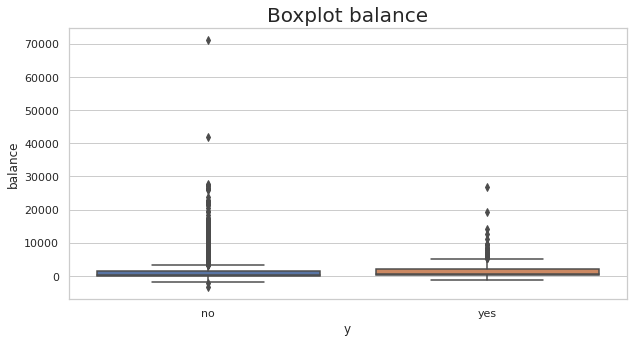

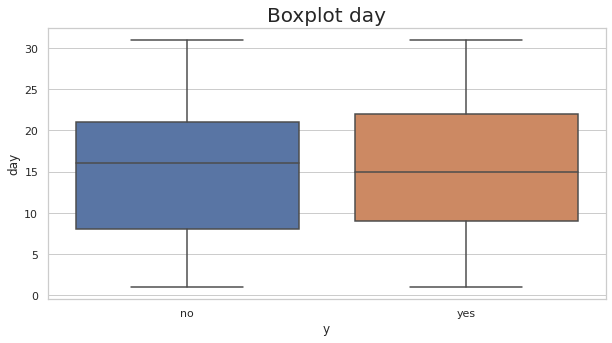

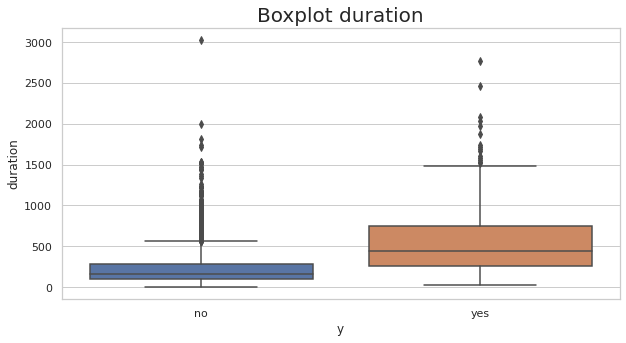

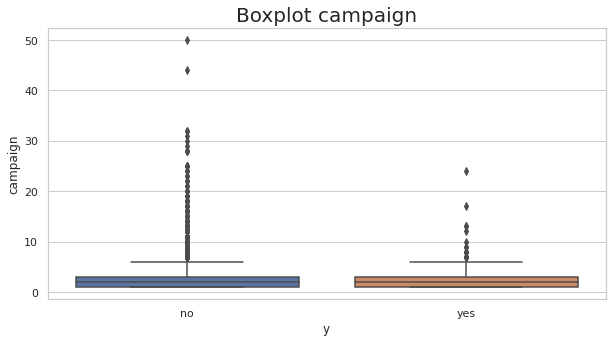

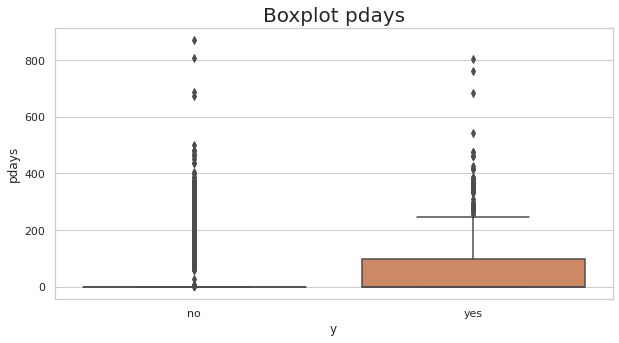

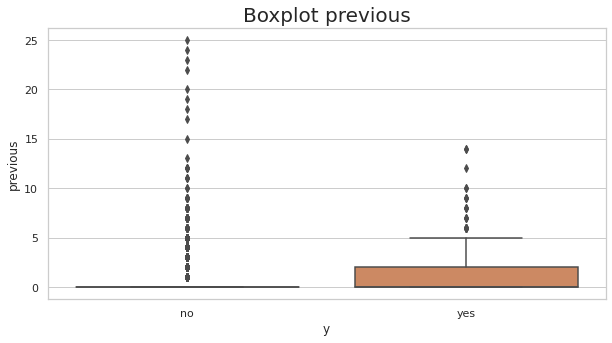

In [17]:
bank = bank_.copy()

for column in bank.columns:
  if bank[column].dtype == 'float' or bank[column].dtype == 'int':
    plt.figure(figsize= (10, 5))
    sns.set(style= 'whitegrid')
    fig1 = sns.boxplot(x= 'y', y= column, data= bank)
    plt.title('Boxplot {}'.format(column), size= 20)
    plt.show()

    print()

#### Attempt after just removing the outliers from all features

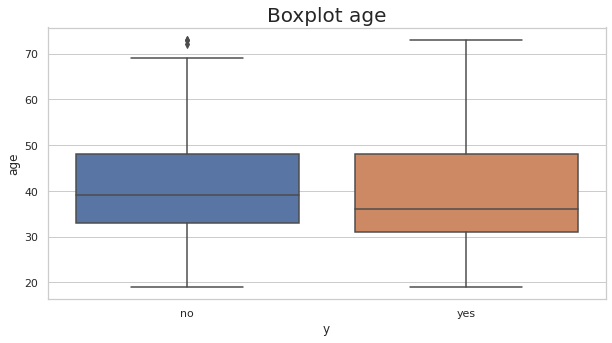

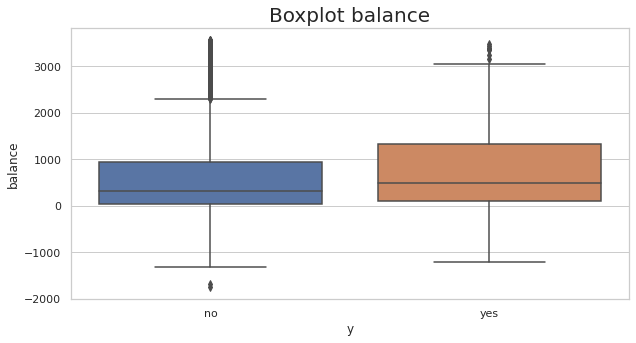

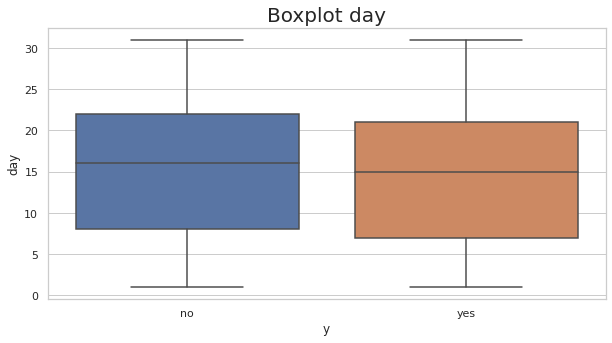

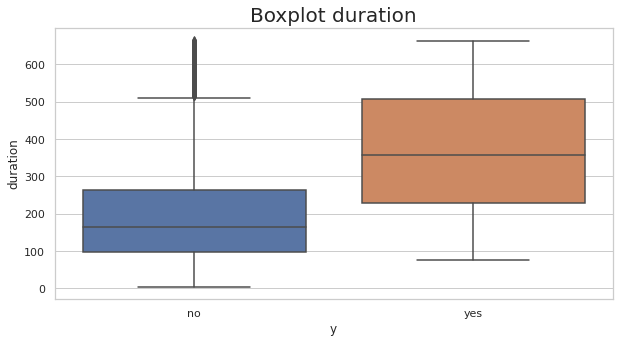

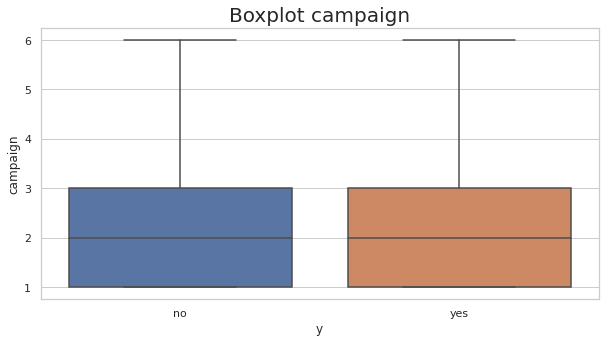

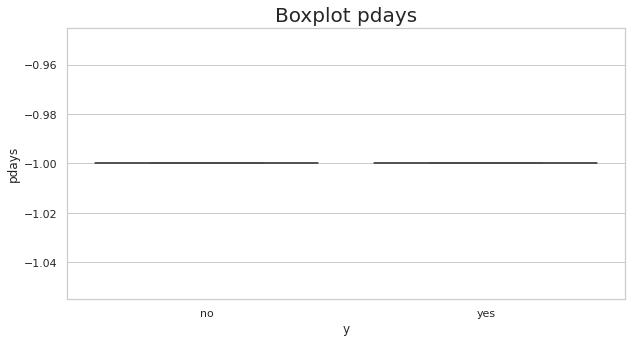

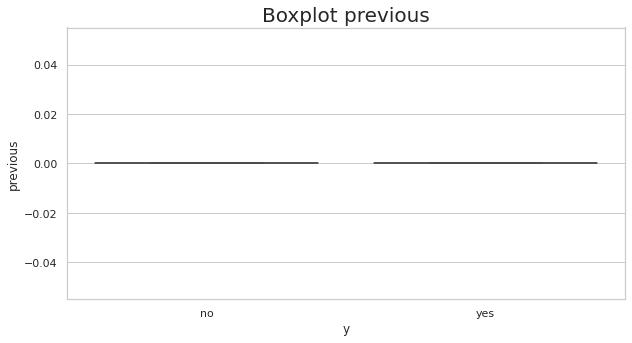


f1: 0.14814814814814814, accuracy score: 0.9452380952380952
[[790   3]
 [ 43   4]]


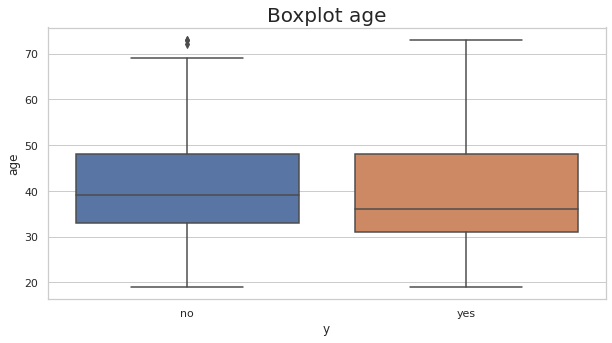

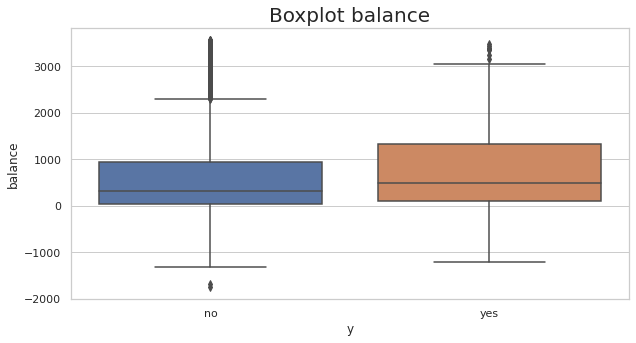

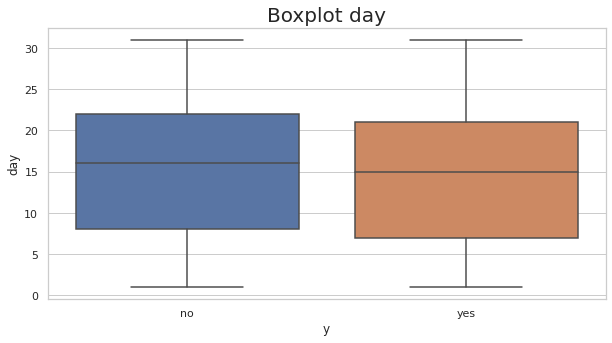

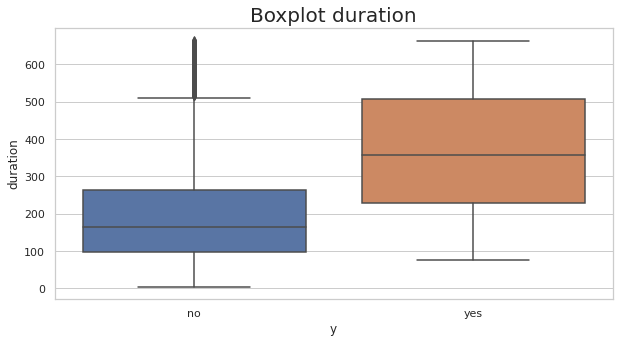

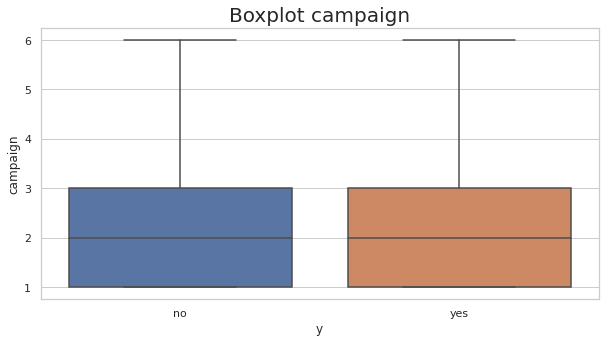

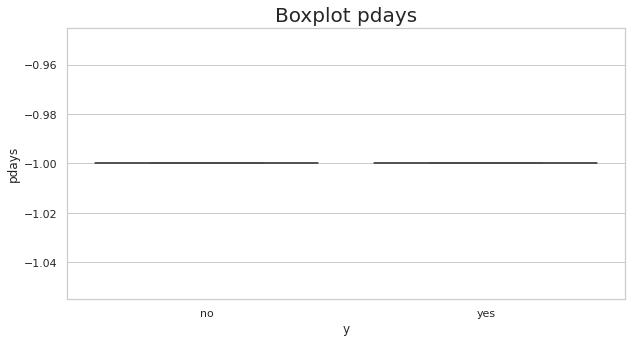

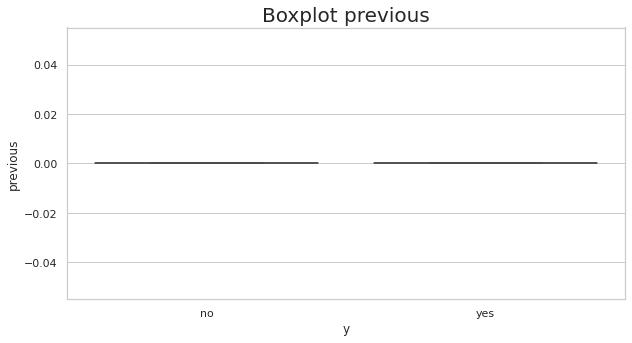


f1: 0.14814814814814814, accuracy score: 0.9452380952380952
[[790   3]
 [ 43   4]]


In [18]:
# removing the outliers
bank = bank_.copy()

for column in bank.columns:
  if bank[column].dtype != 'object':
    q1 = bank[column].quantile(0.25)
    q3 = bank[column].quantile(0.75)
    iq = q3 - q1
    inf = q1 - 1.5 * iq
    sup = q3 + 1.5 * iq 

    filter_ = bank[column].between(inf, sup)
    bank = bank.loc[filter_]

# plotting the new boxplots
for column in bank.columns:
  if bank[column].dtype == 'float' or bank[column].dtype == 'int':
    plt.figure(figsize= (10, 5))
    sns.set(style= 'whitegrid')
    fig1 = sns.boxplot(x= 'y', y= column, data= bank)
    plt.title('Boxplot {}'.format(column), size= 20)
    plt.show()
    print()

# data preprocessing
for column in bank.columns:
  if bank[column].dtype == 'object' or bank[column].dtype == 'str':
    le = LabelEncoder()
    le.fit(bank[column])
    bank[column] = le.transform(bank[column])

x = bank.drop(['y'], axis= 1)
y = bank['y']

x_train, x_test, y_train, y_test = train_test_split(x, y, train_size= 0.7, random_state= 42)

# model training
clf = RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight={1:1, 0:7.5},
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42,
                       verbose=0, warm_start=False)

clf.fit(x_train, y_train)

y_pred = clf.predict(x_test)
y_real = y_test

# metrics
f1 = f1_score(y_real, y_pred)
cm = confusion_matrix(y_real, y_pred)
ac = accuracy_score(y_real, y_pred)

print('f1: {}, accuracy score: {}'.format(f1, ac))
print(cm)

#### As we can clearly see by metrics, just removing the outliers actualy, droped f1 by less than half althought it rised accuracy.